Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [34]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [35]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [36]:
from sklearn.model_selection import train_test_split

# Split the train dataset into training and validation sets
train, val = train_test_split(train, train_size=.8, test_size=.2,
                              stratify=train['status_group'], random_state=42)

# Print the shapes of each of the datasets
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [38]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height',
                       'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # getting rid of columns that are duplicates
    # amount_tsh is almost entirely zeroes, so I am going to drop it
    X = X.drop(columns=['quantity_group', 'payment_type', 'amount_tsh'])
    
    # Converting date recorded column to datetime format
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    # Feature Engeineering 3 separate columns, each holding the year, month, and day of the prevoius
    # date recorded column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day

    # Drop the date recorded column as it is no longer useful to use and expresed
    # in the 3 features we just engineered
    X = X.drop(columns='date_recorded')

    # feature engineer a column that represents the length of time between the construction of 
    # the water pump, and the date it was inspected/recorded
    X['years_before_inspection'] = X['year_recorded'] - X['construction_year']
    X['years_missing'] = X['years_before_inspection'].isnull()

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [39]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assign target to a variable
target = 'status_group'

# prepare X features and y target for ordinal coding
X_train = train.drop(columns=[target, 'id'])
y_train = train[target]
X_val = val.drop(columns=[target, 'id'])
y_val = val[target]
X_test = test.drop(columns=['id'])

# Establish pipeline with ordinal enocoding, simple imputing, standaed scaling, and 
# a random forest classifier model
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=3, n_jobs=-1, max_depth=15)
)

# Fit the model to the training set
pipeline.fit(X_train, y_train)

# Print train and validation accuracy score
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))


Train Accuracy 0.8849326599326599
Validation Accuracy 0.8037878787878788


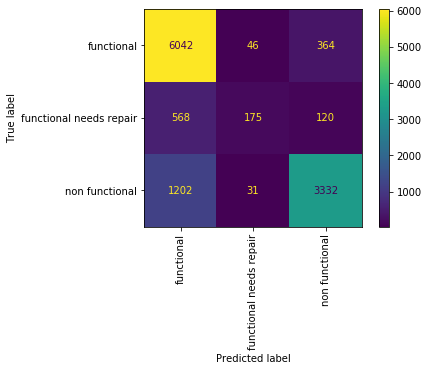

In [40]:
import sklearn

# Look at sklearn version we have
sklearn.__version__

from sklearn.metrics import plot_confusion_matrix

# plot a confustion matrix of the validation set
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [45]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.77      0.94      0.85      6452
functional needs repair       0.69      0.20      0.31       863
         non functional       0.87      0.73      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.78      0.62      0.65     11880
           weighted avg       0.81      0.80      0.79     11880

